In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from statistics import mean
import random

Using TensorFlow backend.


In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
tf.__version__

'1.12.0'

# Construct feature vectors

## Read from source

In [4]:
dir_data = os.path.join("..", "data", "features")
file_training_data = "all_features_6.json"

In [5]:
data_all = json.load(open(os.path.join(dir_data, file_training_data)))

## Construct data

In [6]:
# subcategory category
category_prop = "subcategory"

In [7]:
random.shuffle(data_all, random.random)

In [8]:
dict_labels2id = {}
dict_labels2amount = {}
dict_id2label = {}
dict_sub_categ2categ = {}
temp_data = []
temp_labels = []
temp_test = {}

for entry in data_all:
    for indx, num in enumerate(entry['target_num']):
        fe_vector = (entry['features']['topic_distr'] + 
                     entry['features']['tags_vectors'] + 
                     entry['features']['target_num_feature_vectors'][indx] + 
                     entry['features']['target_num_terms_context_vectors'][indx] +
                     entry['features']['target_num_symbols_context_vectors'][indx])
        if category_prop not in entry:
            temp_test["%s_%s" % (entry["idx"], indx)] = fe_vector
            continue
        if entry[category_prop][indx] not in dict_labels2id:
            label_id = len(dict_labels2id)
            dict_labels2id[entry[category_prop][indx]] = label_id
            dict_id2label[label_id] = entry[category_prop][indx] 
            dict_labels2amount[entry[category_prop][indx]] = 0
            
        label = dict_labels2id[entry[category_prop][indx]]
        dict_labels2amount[entry[category_prop][indx]] += 1
        dict_sub_categ2categ[entry['subcategory'][indx]] = entry['category'][indx]
        
        temp_data.append(fe_vector)
        temp_labels.append(label)    

## Data stats

### Classes

In [9]:
dict_labels2id

{'sell price': 0,
 'quote': 1,
 'buy price': 2,
 'date': 3,
 'absolute': 4,
 'Quantity': 5,
 'relative': 6,
 'Product Number': 7,
 'money': 8,
 'forecast': 9,
 'Indicator': 10,
 'time': 11,
 'exercise price': 12,
 'change': 13,
 'support or resistance': 14,
 'stop loss': 15,
 'maturity date': 16}

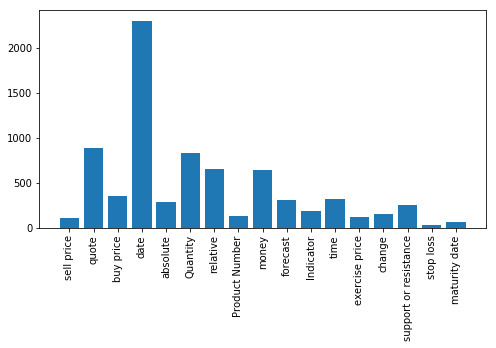

In [10]:
plt.figure(figsize=(8,4))
x = np.arange(len(dict_labels2amount))
data = []
titles = []
for key, val in dict_labels2amount.items():
    data.append(val)
    titles.append(key)
    
plt.bar(x, np.asarray(data))
plt.xticks(x, titles, rotation='vertical')
plt.show()

### Topic distribution

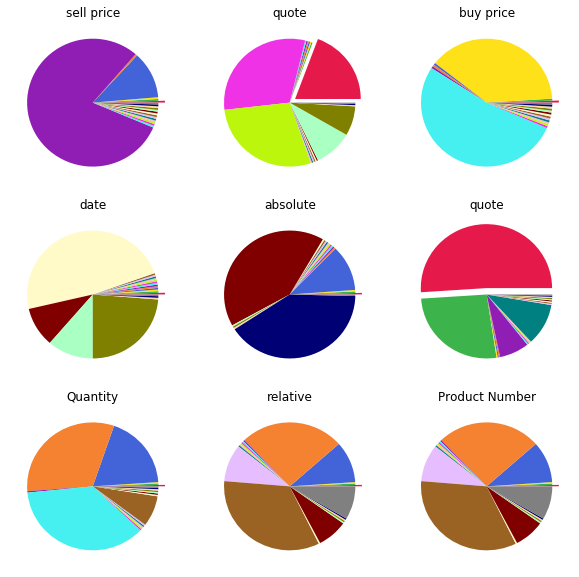

In [11]:
plt.figure(figsize=(10,10))
explode = (0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.pie(np.asarray(temp_data[i][:20]), explode=explode, colors = colors)
    plt.title(dict_id2label[temp_labels[i]])

# Model

In [12]:
global_epochs = 30

In [13]:
def get_model():
    model = keras.Sequential([
        keras.layers.Dense(256, activation=tf.nn.softmax),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation=tf.nn.relu),
        keras.layers.Dense(len(dict_labels2id), activation=tf.nn.softmax)])
    
    model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
    
    return model

## Model Evaluation

### Custom metrics

In [14]:
class F_Metrics(keras.callbacks.Callback):
    # on_train_end  on_epoch_end
    def __get_metrics(self, epoch, logs):
        predict = [np.argmax(x) for x in self.model.predict(self.validation_data[0])]
        targ = self.validation_data[1].flatten()

        _val_f1_micro = f1_score(targ, predict, average="micro")
        _val_f1_macro = f1_score(targ, predict, average="macro")
        
        u_targ = np.unique(targ)
        u_predict = np.unique(predict)
        
        missing_classes = None
        if len(u_targ) - len(u_predict) > 0:
            classes = []
            set_predicted = set(u_predict)
            for class_id in u_targ:
                if class_id not in set_predicted:
                    classes.append(dict_id2label[class_id])
            missing_classes = "[%s]" % ", ".join(classes)
        else:
            missing_classes = "None"
        
        return [_val_f1_micro, _val_f1_macro, missing_classes, np.bincount(predict, minlength=len(u_targ))]

    def on_epoch_end(self, epoch, logs={}):
        if self.params["verbose"] != 0:
            f1_micro, f1_macro, missing_classes, count = self.__get_metrics(epoch, logs)
            print(" - F_micro: %f - F_macro: %f - missing clasees: %s" 
                  % (f1_micro, f1_macro, missing_classes))
        return    
    def on_train_end(self, epoch, logs={}):
        self.model.custom_metrics = self.__get_metrics(epoch, logs)
        return
    
    

### Train & evaluate

In [15]:
def train(train_data, train_label, test_data, test_labels, log=False, plot=True, split_indx=0):
    model = get_model()

    model.fit(train_data, 
              train_label, 
              epochs=global_epochs, 
              verbose=0, 
              validation_data=(test_data, test_labels), 
              callbacks=[F_Metrics()])
    f_micro, f_macro, missing_classes, classes_count = model.custom_metrics
    if log:
        print("Run %s - F_micro: %f - F_macro: %f - missing: %s"
              % (split_indx, f_micro, f_macro, missing_classes))
    if plot:
        titles = list(dict_id2label.values())
        plt.figure(figsize=(4,2))
        x = np.arange(len(dict_id2label))
        plt.bar(x, classes_count)
        plt.xticks(x, titles, rotation='vertical')
        plt.title("Run %s - F_micro: %f - F_macro: %f - missing: %s"
                  % (split_indx, f_micro, f_macro, missing_classes))
        plt.show()
    return [f_micro, f_macro]

In [16]:
def splitNvalidation(n):
    run = 0
    data_len = len(temp_data)
    chunk = data_len // n
    chunk_leftovers = data_len % n
    offset = 0
    result = []
    for i in range(n - 1):
        train_data = np.asarray(temp_data[:offset] + temp_data[offset + chunk:], dtype=np.float32)
        test_data = np.asarray(temp_data[offset:offset + chunk], dtype=np.float32)

        train_label = np.asarray(temp_labels[:offset] + temp_labels[offset + chunk:], dtype=np.uint8)
        test_labels = np.asarray(temp_labels[offset:offset + chunk], dtype=np.uint8)


        result.append(train(train_data, train_label, test_data, test_labels, split_indx = run))
        run += 1
        offset += chunk
    
    #last run with chank and leftovers
    chunk += chunk_leftovers
    train_data = np.asarray(temp_data[:offset] + temp_data[offset + chunk:], dtype=np.float32)
    test_data = np.asarray(temp_data[offset:offset + chunk], dtype=np.float32)

    train_label = np.asarray(temp_labels[:offset] + temp_labels[offset + chunk:], dtype=np.uint8)
    test_labels = np.asarray(temp_labels[offset:offset + chunk], dtype=np.uint8)

    result.append(train(train_data, train_label, test_data, test_labels, split_indx = run))
    
    # returns mean f1_micro, f1_macro
    return [mean([x[i] for x in result]) for i in range(2)]

### Nk fold validation

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


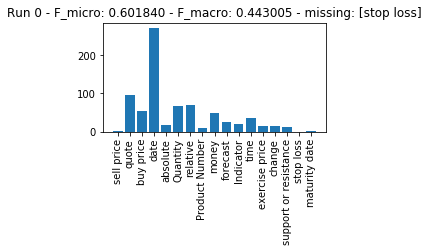

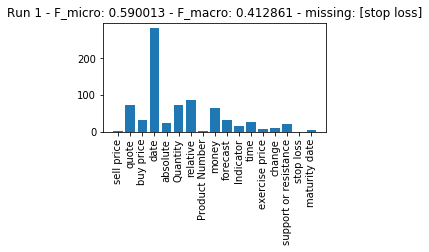

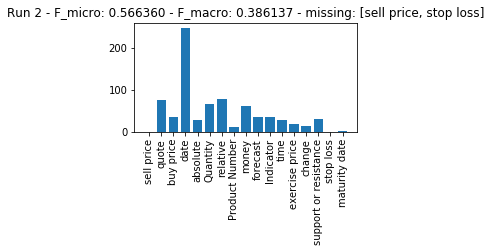

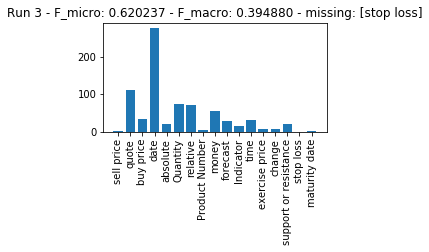

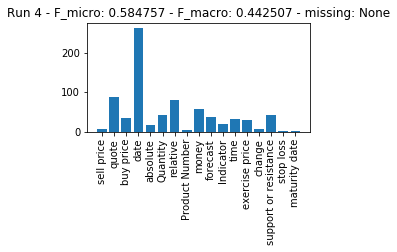

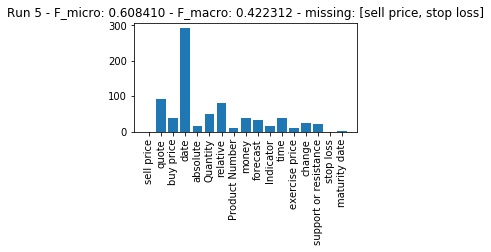

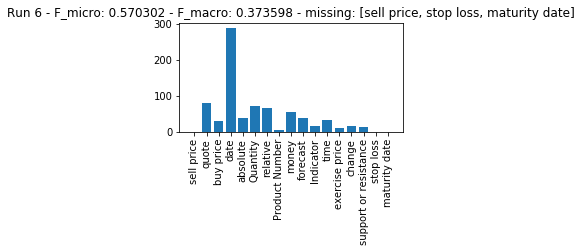

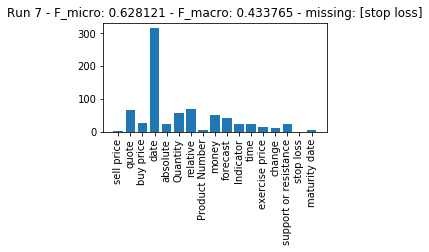

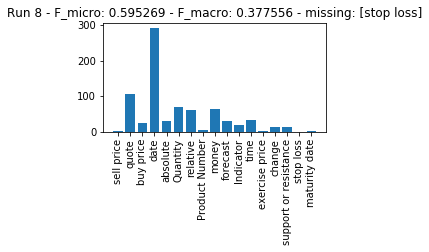

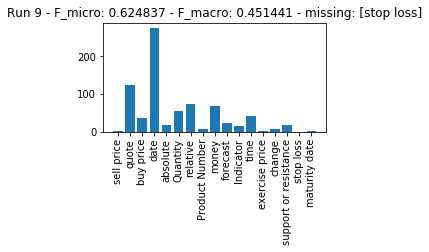

mean F_micro: 0.599015, mean F_macro: 0.413806


In [17]:
mean_f1_micro, mean_f1_macro = splitNvalidation(10)
print("mean F_micro: %f, mean F_macro: %f"
      % (mean_f1_micro, mean_f1_macro))

# Prediction on test data (submmission ready)

### Create data

In [18]:
train_data_array = np.asarray(temp_data, dtype=np.float32)
train_label_array = np.asarray(temp_labels, dtype=np.uint8)

test_data_list = []
test_ids_list = []
for k, v in temp_test.items():
    test_data_list.append(v)
    test_ids_list.append(k)

test_data_array = np.asarray(test_data_list, dtype=np.float32)

### Train model

Train on 7614 samples, validate on 7614 samples
Epoch 1/30
 - F_micro: 0.346861 - F_macro: 0.057562 - missing clasees: [sell price, buy price, absolute, relative, Product Number, forecast, Indicator, time, exercise price, change, support or resistance, stop loss, maturity date]
 - 9s - loss: 2.3883 - acc: 0.3072 - val_loss: 2.0990 - val_acc: 0.3469
Epoch 2/30
 - F_micro: 0.475834 - F_macro: 0.129807 - missing clasees: [sell price, buy price, absolute, Product Number, forecast, Indicator, time, exercise price, change, support or resistance, stop loss, maturity date]
 - 9s - loss: 1.9070 - acc: 0.4314 - val_loss: 1.7050 - val_acc: 0.4758
Epoch 3/30
 - F_micro: 0.524429 - F_macro: 0.186507 - missing clasees: [sell price, buy price, absolute, Product Number, forecast, Indicator, exercise price, change, support or resistance, stop loss, maturity date]
 - 8s - loss: 1.6132 - acc: 0.4912 - val_loss: 1.4932 - val_acc: 0.5244
Epoch 4/30
 - F_micro: 0.550433 - F_macro: 0.228718 - missing clasees

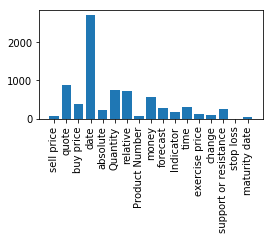

In [19]:
predictive_model = get_model()
predictive_model.fit(
    train_data_array, 
    train_label_array, 
    epochs=global_epochs, 
    verbose=2,
    validation_data=(train_data_array.copy(), train_label_array.copy()), 
    callbacks=[F_Metrics()])

f_micro, f_macro, missing_classes, classes_count = predictive_model.custom_metrics

print("Final Training - F_micro: %f - F_macro: %f - missing: %s"
      % (f_micro, f_macro, missing_classes))

x = np.arange(len(dict_id2label))
plt.figure(figsize=(4,2))
plt.bar(x, classes_count)
plt.xticks(x, list(dict_id2label.values()), rotation='vertical')
plt.show()

In [20]:
predictive_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             multiple                  2244864   
_________________________________________________________________
dropout_10 (Dropout)         multiple                  0         
_________________________________________________________________
dense_31 (Dense)             multiple                  16448     
_________________________________________________________________
dense_32 (Dense)             multiple                  1105      
Total params: 2,262,417
Trainable params: 2,262,417
Non-trainable params: 0
_________________________________________________________________


### Predict

In [21]:
predictions = predictive_model.predict(test_data_array)

### Analsys on submission

###  Save submitions result

In [22]:
key_2_prediction = {}
dict_predicted2amount = {}
for indx in range(len(predictions)):
    predicted_class = np.argmax(predictions[indx])
    if predicted_class not in dict_predicted2amount:
        dict_predicted2amount[predicted_class] = 0
    dict_predicted2amount[predicted_class] +=1
    key_2_prediction[test_ids_list[indx]] = predicted_class
    


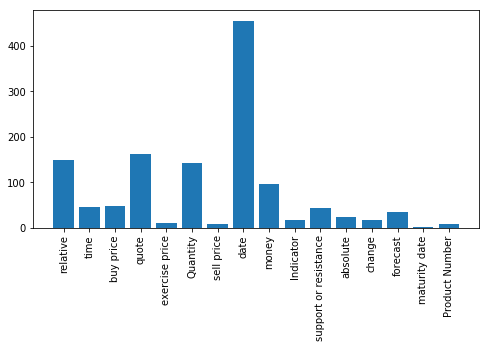

In [23]:
plt.figure(figsize=(8,4))
x = np.arange(len(dict_predicted2amount))
data = []
titles = []
for key, val in dict_predicted2amount.items():
    data.append(val)
    titles.append(dict_id2label[key])
    
plt.bar(x, np.asarray(data))
plt.xticks(x, titles, rotation='vertical')
plt.show()

In [24]:
def save_submission():
    file_2_read = "FinNum_test_from_site.json"
    flle_output = "BRNIR_4.json"
    if category_prop == "subcategory":
        file_2_read = flle_output
    
    with open(os.path.join(dir_data, file_2_read)) as f_r:
        data = json.load(f_r)
        total_conflicts = 0
        total_predictions = 0
        for entry in data:
            result_categories = []
            for indx, num in enumerate(entry["target_num"]):
                total_predictions += 1
                key = "%s_%s" % (entry["idx"], indx)
                
                if key not in key_2_prediction:
                    print("WARN: Misssing prediction for key: %s" % key)
                
                if category_prop == "subcategory":
                    predicted_category = dict_sub_categ2categ[dict_id2label[key_2_prediction[key]]]


                    if predicted_category != entry["category"][indx]:
                        print("%s != %s" %(predicted_category, entry["category"][indx]))
                        print("WARN: Conflict in predicted category and subcategory for key: %s" % key)
                        total_conflicts +=1
                        
                result_categories.append(dict_id2label[key_2_prediction[key]])
            entry[category_prop] = result_categories
        print("Total conflicts %s from %s" % (total_conflicts, len(key_2_prediction)))   
        json.dump(data, open(os.path.join(dir_data, flle_output), 'w'))

In [25]:
save_submission()

Quantity != Temporal
WARN: Conflict in predicted category and subcategory for key: 2901_0
Monetary != Temporal
WARN: Conflict in predicted category and subcategory for key: 475_0
Quantity != Temporal
WARN: Conflict in predicted category and subcategory for key: 2364_0
Monetary != Quantity
WARN: Conflict in predicted category and subcategory for key: 3734_0
Quantity != Temporal
WARN: Conflict in predicted category and subcategory for key: 5701_0
Quantity != Monetary
WARN: Conflict in predicted category and subcategory for key: 8369_0
Quantity != Temporal
WARN: Conflict in predicted category and subcategory for key: 9056_0
Quantity != Monetary
WARN: Conflict in predicted category and subcategory for key: 4693_0
Product Number != Quantity
WARN: Conflict in predicted category and subcategory for key: 9059_0
Temporal != Percentage
WARN: Conflict in predicted category and subcategory for key: 2904_0
Quantity != Temporal
WARN: Conflict in predicted category and subcategory for key: 6604_1
Mon

In [26]:
dict_sub_categ2categ

{'sell price': 'Monetary',
 'quote': 'Monetary',
 'buy price': 'Monetary',
 'date': 'Temporal',
 'absolute': 'Percentage',
 'Quantity': 'Quantity',
 'relative': 'Percentage',
 'Product Number': 'Product Number',
 'money': 'Monetary',
 'forecast': 'Monetary',
 'Indicator': 'Indicator',
 'time': 'Temporal',
 'exercise price': 'Option',
 'change': 'Monetary',
 'support or resistance': 'Monetary',
 'stop loss': 'Monetary',
 'maturity date': 'Option'}